Tutorial: Ply tailoring using SLSPQ for a simply-supported plate normal load
==
Date: 4 February 2026

Author: Saullo G. P. Castro

Cite this tutorial as:

Saullo G. P. Castro. (2025). General-purpose finite element solver based on Python and Cython (Version 0.6.2). Zenodo. DOI: https://doi.org/10.5281/zenodo.6573489.

Installing required modules
--

In [1]:
!python -m pip install numpy pyvista pymoo scipy pyfe3d > tmp.txt

DEPRECATION: Loading egg at /Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/panels-0.5.0-py3.13-macosx-11.1-arm64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/tuduam-2026.3-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
# %load opt-lightweight-smeared-deflection-slsqp-quarter.py
import numpy as np
import pyvista as pv
from pymoo.core.problem import ElementwiseProblem
from scipy.optimize import minimize as scipy_minimize
from scipy.optimize import Bounds
from scipy.sparse.linalg import spsolve
from scipy.sparse import coo_matrix
from pyfe3d.shellprop import ShellProp
from pyfe3d import Quad4, Quad4Data, Quad4Probe, INT, DOUBLE, DOF


def get_Q_matrix(E1, E2, nu12, G12, G13, G23, theta_deg):
    """
    Calculate the transformed reduced stiffness matrix Q_bar for a given angle.
    """
    nu21 = nu12 * E2 / E1
    denom = 1 - nu12 * nu21
    Q11 = E1 / denom
    Q22 = E2 / denom
    Q12 = nu12 * E2 / denom
    Q66 = G12

    c = np.cos(np.radians(theta_deg))
    s = np.sin(np.radians(theta_deg))

    c2 = c**2; s2 = s**2; c4 = c**4; s4 = s**4

    Q_bar_11 = Q11*c4 + 2*(Q12 + 2*Q66)*s2*c2 + Q22*s4
    Q_bar_22 = Q11*s4 + 2*(Q12 + 2*Q66)*s2*c2 + Q22*c4
    Q_bar_12 = (Q11 + Q22 - 4*Q66)*s2*c2 + Q12*(s4 + c4)
    Q_bar_66 = (Q11 + Q22 - 2*Q12 - 2*Q66)*s2*c2 + Q66*(s4 + c4)

    Q_bar_44 = G23 * c2 + G13 * s2
    Q_bar_55 = G13 * c2 + G23 * s2
    Q_bar_45 = (G13 - G23) * c * s

    Q_bar = np.array([
        [Q_bar_11, Q_bar_12, 0, 0, 0, 0],
        [Q_bar_12, Q_bar_22, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, Q_bar_44, Q_bar_45, 0],
        [0, 0, 0, Q_bar_45, Q_bar_55, 0],
        [0, 0, 0, 0, 0, Q_bar_66]
    ])
    return Q_bar


class SmearedPlateOptimization(ElementwiseProblem):
    def __init__(self, nx, ny, a, b, load_val, max_deflection, h_min, h_max, mat_data):
        self.nx = nx
        self.ny = ny
        self.n_elems = (self.nx - 1)*(self.ny - 1)
        self.a = a
        self.b = b
        self.load_val = load_val
        self.max_deflection = max_deflection
        self.rho = mat_data['rho']

        # Pre-calculate Base Q matrices
        E1, E2 = mat_data['E1'], mat_data['E2']
        nu12, G12 = mat_data['nu12'], mat_data['G12']
        G13, G23 = mat_data['G13'], mat_data['G23']

        num_orientations = 3

        self.Q0 = get_Q_matrix(E1, E2, nu12, G12, G13, G23, 0)
        self.Q90 = get_Q_matrix(E1, E2, nu12, G12, G13, G23, 90)
        self.Q45p = get_Q_matrix(E1, E2, nu12, G12, G13, G23, 45)
        self.Q45m = get_Q_matrix(E1, E2, nu12, G12, G13, G23, -45)
        self.Q45_sum = self.Q45p + self.Q45m

        self.eid_prop = {}

        n_var = num_orientations*self.n_elems

        self._init_fe_model()

        # We keep this for context, though Scipy doesn't read it directly
        super().__init__(n_var=n_var, n_obj=1,
                         n_ieq_constr=1,
                         xl=h_min,
                         xu=h_max)

    def _init_fe_model(self):
        data = Quad4Data()
        probe = Quad4Probe()

        xtmp = np.linspace(0, self.a/2, self.nx)
        ytmp = np.linspace(0, self.b/2, self.ny)
        xmesh, ymesh = np.meshgrid(xtmp, ytmp)
        ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten(), np.zeros_like(ymesh.T.flatten()))).T
        self.ncoords = ncoords
        x = ncoords[:, 0]
        y = ncoords[:, 1]
        z = ncoords[:, 2]
        ncoords_flatten = ncoords.flatten()
        self.ncoords_flatten = ncoords_flatten

        nids = 1 + np.arange(ncoords.shape[0])
        nid_pos = dict(zip(nids, np.arange(len(nids))))
        nids_mesh = nids.reshape(self.nx, self.ny)
        n1s = nids_mesh[:-1, :-1].flatten()
        n2s = nids_mesh[1:, :-1].flatten()
        n3s = nids_mesh[1:, 1:].flatten()
        n4s = nids_mesh[:-1, 1:].flatten()

        num_elements = len(n1s)

        self.KC0r = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
        self.KC0c = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
        self.KC0v = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=DOUBLE)
        self.N = DOF*self.nx*self.ny

        self.quads = []
        init_k_KC0 = 0
        eid = -1
        for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
            #NOTE dummy property
            prop = ShellProp()
            prop.scf_k13 = 5/6.
            prop.scf_k23 = 5/6.
            eid += 1
            self.eid_prop[eid] = prop

            pos1 = nid_pos[n1]
            pos2 = nid_pos[n2]
            pos3 = nid_pos[n3]
            pos4 = nid_pos[n4]
            r1 = ncoords[pos1]
            r2 = ncoords[pos2]
            r3 = ncoords[pos3]
            normal = np.cross(r2 - r1, r3 - r2)[2]
            assert normal > 0
            quad = Quad4(probe)
            quad.eid = eid
            quad.n1 = n1
            quad.n2 = n2
            quad.n3 = n3
            quad.n4 = n4
            quad.c1 = DOF*nid_pos[n1]
            quad.c2 = DOF*nid_pos[n2]
            quad.c3 = DOF*nid_pos[n3]
            quad.c4 = DOF*nid_pos[n4]
            quad.init_k_KC0 = init_k_KC0
            quad.update_rotation_matrix(ncoords_flatten)
            quad.update_probe_xe(ncoords_flatten)
            quad.update_KC0(self.KC0r, self.KC0c, self.KC0v, prop)
            self.quads.append(quad)
            init_k_KC0 += data.KC0_SPARSE_SIZE

    def _evaluate(self, var, out, *args, **kwargs):
        total_volume = 0.0

        #NOTE important line below to zero the sparse matrix container
        self.KC0v *= 0

        for i, quad in enumerate(self.quads):
            prop = self.eid_prop[quad.eid]
            h0 = var[3*i]
            h45 = var[3*i + 1]
            h90 = var[3*i + 2]

            h_total = h0 + 2*h45 + h90

            A = (h0 * self.Q0) + (h90 * self.Q90) + (h45 * self.Q45_sum)
            D = (h_total**2 / 12.0) * A

            # NOTE using the full Voigt notation indices
            # membrane stiffness
            prop.A11 = A[0, 0]
            prop.A12 = A[0, 1]
            prop.A22 = A[1, 1]
            prop.A66 = A[5, 5]

            # transverse shear stiffness, the SCF is applied in pyfe3d
            prop.E44 = A[3, 3]
            prop.E45 = A[3, 4]
            prop.E55 = A[4, 4]

            # bending stiffness
            prop.D11 = D[0, 0]
            prop.D12 = D[0, 1]
            prop.D22 = D[1, 1]
            prop.D66 = D[5, 5]

            prop.h = h_total

            quad.update_probe_xe(self.ncoords_flatten)
            quad.update_KC0(self.KC0r, self.KC0c, self.KC0v, prop, update_KC0v_only=1)

            total_volume += quad.area * h_total

        KC0 = coo_matrix((self.KC0v, (self.KC0r, self.KC0c)), shape=(self.N, self.N)).tocsc()

        bk = np.zeros(self.N, dtype=bool)

        x = self.ncoords[:, 0]
        y = self.ncoords[:, 1]
        z = self.ncoords[:, 2]

        # removing in-plane motion
        bk[0::DOF] = True #NOTE u displacements
        bk[1::DOF] = True #NOTE v displacements

        at_edges = np.isclose(x, 0.) | np.isclose(y, 0.)
        bk[2::DOF][at_edges] = True #NOTE w displacements

        at_sym_along_x = np.isclose(x, self.a/2)
        bk[5::DOF][at_sym_along_x] = True

        at_sym_along_y = np.isclose(y, self.b/2)
        bk[4::DOF][at_sym_along_y] = True

        bu = ~bk

        # point load at center node
        fext = np.zeros(self.N)
        fmid = self.load_val
        check = np.isclose(x, self.a/2) & np.isclose(y, self.b/2)
        fext[2::DOF][check] = fmid

        KC0uu = KC0[bu, :][:, bu]

        # checking load balance
        assert fext[bu].sum() == fmid

        # solving the static system
        uu = spsolve(KC0uu, fext[bu])

        u = np.zeros(self.N)
        u[bu] = uu

        # reading the deflections in the z direction
        w = u[2::DOF].reshape(self.nx, self.ny).T

        self.result_w = u[2::DOF]

        # reading the maximum absolute deflection
        w_max = np.max(np.abs(w))

        out["F"] = 4*total_volume
        out["G"] = w_max/self.max_deflection - 1

# --- 3. Wrapper Functions for Scipy ---
# Scipy expects separate functions for objective and constraints
def objective_function(x, problem):
    out = {}
    problem._evaluate(x, out)
    return out["F"]

def constraint_function(x, problem):
    out = {}
    problem._evaluate(x, out)
    # Scipy inequality constraints are 'fun(x) >= 0'
    # Pymoo constraints are 'G(x) <= 0' => 'w_max/allow - 1 <= 0'
    # Equivalent to: '1 - w_max/allow >= 0'
    # So we return -G
    return -out["G"]


In [3]:
if __name__ == "__main__":
    # Material Data (Carbon/Epoxy approx)
    mat_data = {
        'E1': 140e9,
        'E2': 10e9,
        'nu12': 0.3,
        'G12': 5e9,
        'G13': 5e9,
        'G23': 5e9,
        'rho': 1600.0
    }

    h_min = 0.125e-3
    h_max = 2.5e-3

    problem = SmearedPlateOptimization(
        nx=13, ny=7,
        a=2.0, b=1.0,
        load_val=80.0,
        max_deflection=0.001,
        h_min=h_min,
        h_max=h_max,
        mat_data=mat_data
    )

    # Scipy Setup
    x0 = np.ones(problem.n_var) * (h_min + h_max) / 2.0
    bounds = Bounds([h_min]*problem.n_var, [h_max]*problem.n_var)

    # Inequality constraint: fun(x) >= 0
    # We use a lambda to pass 'problem' into the function
    cons = {'type': 'ineq', 'fun': lambda x: constraint_function(x, problem)}

    print("Starting SLSQP Optimization with Scipy...")

    # Helper to print progress
    iteration = 0
    def print_callback(xk):
        global iteration
        iteration += 1
        # Re-eval to get current Mass (optional, slows down slightly but gives info)
        out = {}; problem._evaluate(xk, out)
        print(f"Iter {iteration}: Volume = {out['F']:.4f} m^3, Constraint G = {out['G']:.4e}")

    res = scipy_minimize(
        lambda x: objective_function(x, problem),
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=cons,
        callback=print_callback,
        options={'ftol': 1e-6, 'disp': True, 'maxiter': 200},
        jac="2-point"
    )

    print("\nOptimization Complete.")
    print(f"Success: {res.success}")
    print(f"Message: {res.message}")

    out_final = {}
    problem._evaluate(res.x, out_final)
    print(f"Final Mass: {out_final['F']:.4f} kg")
    print(f"Final Constraint Violation: {out_final['G']:.4e}")

Starting SLSQP Optimization with Scipy...
Iter 1: Volume = 0.0080 m^3, Constraint G = 6.1859e+00
Iter 2: Volume = 0.0077 m^3, Constraint G = 4.5228e+00
Iter 3: Volume = 0.0073 m^3, Constraint G = 4.2768e+00
Iter 4: Volume = 0.0071 m^3, Constraint G = 5.5381e+00
Iter 5: Volume = 0.0070 m^3, Constraint G = 7.4929e+00
Iter 6: Volume = 0.0070 m^3, Constraint G = 6.4033e+00
Iter 7: Volume = 0.0071 m^3, Constraint G = 6.5783e+00
Iter 8: Volume = 0.0072 m^3, Constraint G = 7.7092e-01
Iter 9: Volume = 0.0071 m^3, Constraint G = 4.8109e-01
Iter 10: Volume = 0.0057 m^3, Constraint G = 3.0794e+00
Iter 11: Volume = 0.0059 m^3, Constraint G = 2.0017e+00
Iter 12: Volume = 0.0064 m^3, Constraint G = 3.6107e+00
Iter 13: Volume = 0.0064 m^3, Constraint G = 4.5622e+00
Iter 14: Volume = 0.0062 m^3, Constraint G = 1.2662e+00
Iter 15: Volume = 0.0063 m^3, Constraint G = 9.3601e-01
Iter 16: Volume = 0.0063 m^3, Constraint G = 3.9440e-01
Iter 17: Volume = 0.0061 m^3, Constraint G = 3.7923e+00
Iter 18: Volume

/Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


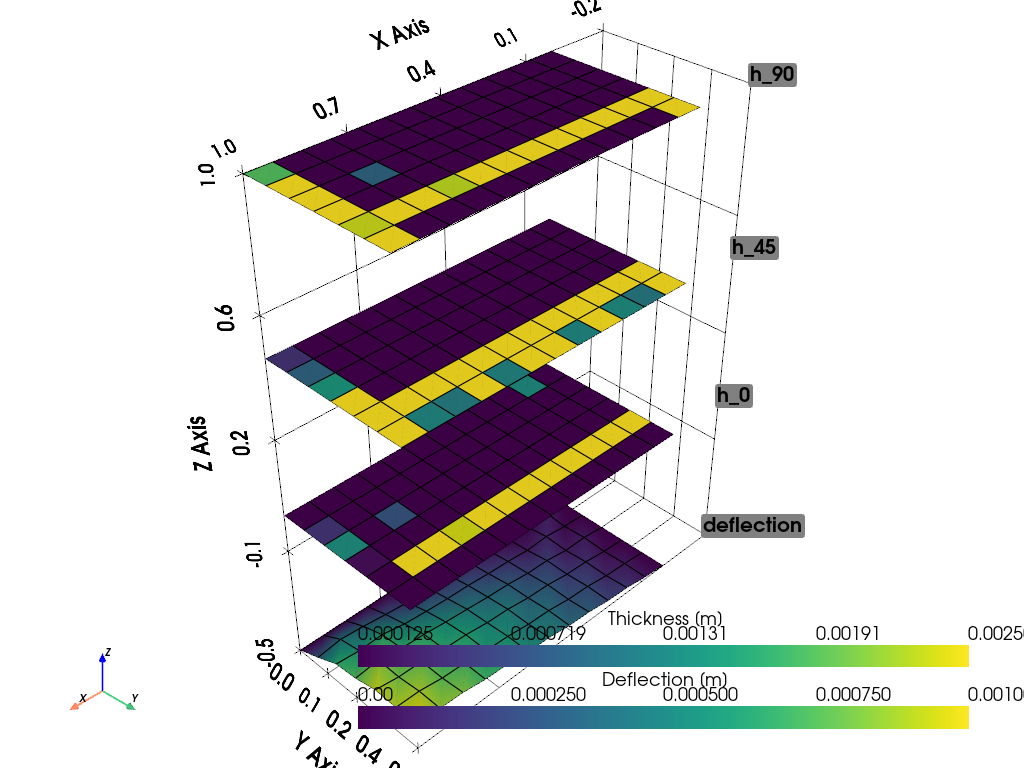

In [4]:
def plot_results(problem, x_best):
    ncoords = problem.ncoords
    faces_quad = []
    for quad in problem.quads:
        faces_quad.append([4, quad.n1 - 1, quad.n2 - 1, quad.n3 - 1, quad.n4 - 1])
    faces_quad = np.hstack(faces_quad)

    base_grid = pv.PolyData(ncoords, faces_quad)

    # Re-evaluate to ensure result_w is updated
    problem._evaluate(x_best, out={})

    h0_vals = x_best[0::3]
    h45_vals = x_best[1::3]
    h90_vals = x_best[2::3]

    z_offset = min(problem.a, problem.b) * 0.5

    # --- Layer 0: deflection ---
    grid_w = base_grid.copy()
    grid_w.points[:, 2] -= z_offset
    grid_w.point_data["Deflection [m]"] = problem.result_w
    grid_w = grid_w.warp_by_scalar("Deflection [m]", factor=100.0)

    # --- Layer 1: 0 degrees ---
    grid_h0 = base_grid.copy()
    grid_h0.cell_data["Thickness [m]"] = h0_vals

    # --- Layer 2: +/- 45 degrees ---
    grid_h45 = base_grid.copy()
    grid_h45.points[:, 2] += z_offset
    grid_h45.cell_data["Thickness [m]"] = h45_vals

    # --- Layer 3: 90 degrees ---
    grid_h90 = base_grid.copy()
    grid_h90.points[:, 2] += 2 * z_offset
    grid_h90.cell_data["Thickness [m]"] = h90_vals

    plotter = pv.Plotter()
    cmap = "viridis"

    plotter.add_mesh(grid_w, scalars="Deflection [m]", cmap=cmap, show_edges=True)
    plotter.add_mesh(grid_h0, scalars="Thickness [m]", cmap=cmap, show_edges=True)
    plotter.add_mesh(grid_h45, scalars="Thickness [m]", cmap=cmap, show_edges=True)
    plotter.add_mesh(grid_h90, scalars="Thickness [m]", cmap=cmap, show_edges=True)

    label_x = -problem.a * 0.1
    label_y = problem.b / 2

    labels = ["deflection", "h_0", "h_45", "h_90"]
    label_coords = [
        [label_x, label_y, -z_offset],
        [label_x, label_y, 0],
        [label_x, label_y, z_offset],
        [label_x, label_y, 2 * z_offset]
    ]

    plotter.add_point_labels(
        label_coords,
        labels,
        font_size=20,
        point_size=0,
        text_color="black",
        always_visible=True
    )

    plotter.add_axes()
    plotter.show_grid()
    plotter.view_isometric()
    plotter.show(title="Optimized Thickness Distribution per Orientation")

    
plot_results(problem, res.x)